# Text Clustering Assignment by:
- Yusri Al-Sanaani
- Hetvi Soni
- Tavleen Kour
- Immanuella Iyawe

Group: Group: DSA_202101_ 7

**Clustering is a process of grouping similar items together.**
- Each group or cluster contains items that are similar to each other. - Clustering algorithms are unsupervised learning algorithms (no need for labelled datasets). 
- The choice of the algorithm mainly depends on whether or not you already know how many clusters to create. 
- Some algorithms such as KMeans need you to specify number of clusters to create whereas Density-Based Spatial Clustering of Applications with Noise (DBSCAN) does not need you to specify. 
- Another consideration is whether you need the trained model to able to predict cluster for unseen dataset.

---
### Import the required libraries
---

In [ ]:
import re   
import nltk
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **Data Preparation**

In this assignemnt, we’ll cluster text data into different categories. 
- First download the some books from gutenberg to create a dataset.
- The dataset consists of five different books for different authors.
- The genres of the books can be categorized into 5 categories:
 - Metaphysical Thriller
 - Children's Literature
 - Poetry
 - Epic poetry,Christian Mythology
 - Romance Novel
- For most part, we’ll ignore the labels but we’ll use them while evaluating the trained model since many of the evaluation metrics need the “true” labels.
 


---
# Import some books
---

In [ ]:
nltk.download('gutenberg')
book1 = nltk.corpus.gutenberg.raw('chesterton-thursday.txt')
#book2 = nltk.corpus.gutenberg.raw('carroll-alice.txt')
book2 = nltk.corpus.gutenberg.raw('edgeworth-parents.txt')
book3 = nltk.corpus.gutenberg.raw('whitman-leaves.txt')
book4 = nltk.corpus.gutenberg.raw('milton-paradise.txt')
book5 = nltk.corpus.gutenberg.raw('austen-sense.txt')
# Create a list of books
books=[book1,book2,book3,book4,book5]

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


In [ ]:
genres=['Metaphysical Thriller', "Children's Literature",
        'Poetry','Epic poetry,Christian Mythology','Romance Novel']

## Extract the books titles and authors names using regex

In [ ]:
# Extract the books_titles and authors_names by creating a regex pattern 
# that match book title, author name, and year of publication:
def titles_authors(books):
    books_authors_names=[]
    for book in books:
        la=re.findall("(\[[ a-zA-Z0-9 '_.+-|\]+ by [ a-zA-Z0-9-]+|\.[ a-zA-Z0-9-.]+\])", book)
        books_authors_names.append(''.join(la[0]))
        # Now, we can remove special characters, numbers,and right/left white space
        # to get only the book title and author name:
    clean_books_authors_names=[]
    for i in range(len(books_authors_names)):
        clean_names=re.sub(r'[\d+\\!"#$%&()*+,-./:;?@[\]^_`{|}~]',' ',books_authors_names[i]).strip() 
        split_names=re.split('by',clean_names)
        clean_books_authors_names.append(split_names)
    return books_authors_names,clean_books_authors_names

In [ ]:
# Create book_names list and authors_labels list

def title_author(clean_books_authors_names):
    def list_split(lst):
        return lst[:(len(lst)//2)], lst[(len(lst)//2):]
    books_names=[]
    authors_names=[]
    for i in range(len(clean_books_authors_names)):
        book, author = list_split(clean_books_authors_names[i])
        books_names.append(''.join(book).strip())
        authors_names.append(''.join(author).strip())
    # Create an automatic list for authors last name:
    authors_labels=[]
    for i in range(len(authors_names)):
        authors_labels.append(authors_names[i].split()[-1])
    return books_names,authors_labels

In [ ]:
# books_authors_names before cleaning
books_authors_names,clean_books_authors_names=titles_authors(books)
#print('The book title, author name, and year of publication:')
#books_authors_names

In [ ]:
# books_authors_names after cleaning
#clean_books_authors_names

In [ ]:
# we need list of books titles and authors
books_titles,authors=title_author(clean_books_authors_names)
# list of books titles
#books_titles

In [ ]:
# also we need a list of authors ['Chesterton','Carroll','Whitman','Milton','Bryant']
#authors

In [ ]:
# Display the books and the curresponding authors
books_authors=pd.DataFrame({'Book Title':books_titles, 'Authors':authors,'Genres':genres},index=[1,2,3,4,5])
books_authors

,Book Title,Authors,Genres
1,The Man Who Was Thursday,Chesterton,Metaphysical Thriller
2,The Parent's Assistant,Edgeworth,Children's Literature
3,Leaves of Grass,Whitman,Poetry
4,Paradise Lost,Milton,"Epic poetry,Christian Mythology"
5,Sense and Sensibility,Austen,Romance Novel


# Create a general function to clean the data of multiple books
This function takes list of books as input and returns a list of cleaned books. The cleaning includes:

- Removing multiple spaces and left/right white spaces.
- Conevrting capital characters to lower case
- Removing special characters
- Removing single character word

## Clean the data of multiple books

In [ ]:
def get_clean_text(textbooks_data):
    cleaned_books=[]
    for book in textbooks_data:
        single_lower= re.sub(r'\s+',' ',book).lower() # Multiple space removal and conevrt to lower case
        #clean_text = re.sub(r'[\\!"#$%&()*+,-./:;?@[\]^_`{|}~]',' ',single_lower).strip() # Remove special characters
        clean_text = re.sub('[^a-zA-Z]',' ', single_lower)
        #clean_text = re.sub(r"\s+[a-zA-Z]\s+", ' ', clean_text) # remove single character word
        cleaned_books.append(clean_text)
    return cleaned_books

In [ ]:
cleaned_books=get_clean_text(books)

## Defining a function to partition multiple books (get_chunks() function):
- This function takes dict as input  that contains the labels (books and authors names) and books content.
- It returns a list of partitioned books with labeling each partition to the book it belongs to.

## Partition multiple books

In [ ]:
# partitioning the text data with auto labeling 
def get_chunks(chunk_books_dict):
    import nltk
    nltk.download('punkt')
    chunk_books=[]
    chunk_books_labels=[]
    for label,book in chunk_books_dict.items():
        #splits = book.split()
        tokenized_word=nltk.word_tokenize(book)
        labeled_chunks=[]
        chunks_labels=[]
        for i in range(0,len(tokenized_word),150):
            #labeled_chunks.append((' '.join(tokenized_word[i:150+i]),label))
            labeled_chunks.append(' '.join(tokenized_word[i:150+i]))
            chunks_labels.append(label)
        chunk_books.append(labeled_chunks)
        chunk_books_labels.append(chunks_labels)
    return chunk_books,chunk_books_labels

In [ ]:
# uncleaned books books
uncleaned_chunk_books_dict={}
for i,book in enumerate(books):
    uncleaned_chunk_books_dict[authors[i]]=book
chunk_books1,chunk_books_labels1=get_chunks(uncleaned_chunk_books_dict)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#chunk_books_dict1=dict(zip(authors_labels,cleaned_books))
chunk_books_dict={}
for i,book in enumerate(cleaned_books):
    chunk_books_dict[authors[i]]=book
chunk_books,chunk_books_labels=get_chunks(chunk_books_dict)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Check if each book contains enough text data to ensure getting 200 chunks
for i,book in enumerate(chunk_books):
    if len(book)<200:
        print('The book # {} does not contain enough text data (it has only {} chunks).'.format(i+1,len(book)))
    else:
        print("The book # {} contains {} chunks.".format(i+1,len(book)))

The book # 1 contains 392 chunks.
The book # 2 contains 1139 chunks.
The book # 3 contains 843 chunks.
The book # 4 contains 537 chunks.
The book # 5 contains 806 chunks.


## Creating random samples of 200 partitions for each book
Defining a function to return 200 random chunks for each book(get_random_chunks function):
- This function takes a list of previously partioned books as input.
- It returns a list of books conataining 200 random chunks each.

In [ ]:

def get_random_chunks(chunk_books):
    import random
    random.seed(1)
    random_chunks=[]
    for book in chunk_books:
        chunks=random.sample(book, 200)
        random_chunks.append(chunks)
    return random_chunks

## Creating random samples of 200 partitions for each book

In [ ]:
books_random_chunks_uncleaned=get_random_chunks(chunk_books1)
books_random_chunks=get_random_chunks(chunk_books)
#print(random_chunks[0][0],'\n\n',random_chunks[1][0])
# Check if each book contains enough text data to ensure getting 200 chunks
for i,book in enumerate(books_random_chunks):
    print("The book # {} contains {} chunks.".format(i+1,len(book)))

The book # 1 contains 200 chunks.
The book # 2 contains 200 chunks.
The book # 3 contains 200 chunks.
The book # 4 contains 200 chunks.
The book # 5 contains 200 chunks.


## Create data frame

In [ ]:
# Uncleaned dataframe
df_books1=pd.DataFrame()
for i in range(len(books_random_chunks)):
    dfs=pd.DataFrame({'Book Text Data':books_random_chunks_uncleaned[i],'Author':chunk_books_labels1[i][:200]})
    df_books1=df_books1.append(dfs)

df_books1.reset_index(drop=True,inplace=True)
df_books1.sample(5)

,Book Text Data,Author
12,", that the others , though already well at the...",Chesterton
816,by which she offended Mrs. Ferrars and Fanny s...,Austen
741,"which he calls justice , bids -- His wrath , w...",Milton
203,one belonging to the Manor of East or Great Wr...,Edgeworth
110,near snapping under that strain of motionless ...,Chesterton


# **Feature Engineering**

## Clean the text

In [ ]:
# Cleaned text
df_books=pd.DataFrame()
for i in range(len(books_random_chunks)):
    dfs=pd.DataFrame({'books_text_data':books_random_chunks[i],'authors_labels':chunk_books_labels[i][:200]})
    df_books=df_books.append(dfs)
df_books.reset_index(drop=True,inplace=True)
df_books.sample(5)

,books_text_data,authors_labels
825,made him cold hearted and selfish vanity while...,Austen
202,well he can afford it and i do love to see my ...,Edgeworth
60,great moment is not the creation of light but ...,Chesterton
238,in the village the old gardener francisco s fa...,Edgeworth
935,was i believe fervent as the attachment of you...,Austen


In [ ]:
frames=dict(('Book {}'.format(i+1),book) for i, book in enumerate(books_random_chunks))
books_frames=pd.DataFrame(frames)
books_frames.sample(5)

,Book 1,Book 2,Book 3,Book 4,Book 5
123,and the wooded hills looked down upon this imb...,preferred their own summary mode of proceeding...,with ranging hills on the banks with many a li...,heaven and heavenly born here in perpetual ago...,together in a most promising state of embarras...
72,great personality they might have called sunda...,in jersey and guernsey situate scarcely one de...,soul where you stand surrounded detached in me...,made me here thy substitute and these inferiou...,might safely under the shelter of its noise in...
64,believe that the professor had fallen in love ...,for talbot talbot for ever huzza exit enter wh...,cry everywhere the flags flung out from the st...,the tempter all impassioned thus began o sacre...,not as i did even now her self command is inva...
87,i want to go by the train we know all said the...,without obedience to the laws added he turning...,inloop d flags with the cities draped in black...,which is left so to defend encroached on still...,ignorant and illiterate and her deficiency of ...
23,he will never get anything out of that old hea...,which though decayed in some parts by time was...,world i will confront these shows of the day a...,hast vouchsafed to enter and these earthly fru...,lucy herself he had been for some time he beli...


## Stop words removal

In [ ]:
# remove Stopwords
def remove_stopwords(books_text_data):
    nltk.download('stopwords')
    stop_words = nltk.corpus.stopwords.words("english")
    splited_text=books_text_data.str.split()
    text_no_stopwords=[]
    for i in range(len(splited_text)):
        text_no_stopwords1 = [word for word in splited_text[i] if word not in stop_words]
        text_no_stopwords.append(' '.join(text_no_stopwords1))
    return text_no_stopwords

In [ ]:
a=remove_stopwords(df_books['books_text_data'])
df_books['text_no_stopwords']=a; df_books.sample(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,books_text_data,authors_labels,text_no_stopwords
978,be less elinor pleased to have her governed fo...,Austen,less elinor pleased governed moment motive tho...
670,a wonder strange of every beast and bird and i...,Milton,wonder strange every beast bird insect small c...
975,robbed her of the power of regarding him after...,Austen,robbed power regarding entering house seen eno...
330,ay darling her father s own child how was it c...,Edgeworth,ay darling father child child caught thief mai...
15,one of them rode behind bruce at bannockburn s...,Chesterton,one rode behind bruce bannockburn since tree q...


## Lemmatization and Stemming

In [ ]:
# Lemmatisation (convert the word into root word)
def lemmatisation(books_text_data):
    nltk.download('wordnet')
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    splited_text=books_text_data.str.split()
    lemmatized_words=[]
    for i in range(len(splited_text)):
        lemmatized_words1 =' '.join([lem.lemmatize(word) for word in splited_text[i]])
        lemmatized_words.append(lemmatized_words1)
    return lemmatized_words

#Stemming
def stem_word(books_text_data):
    ps=nltk.stem.porter.PorterStemmer()
    splited_text=books_text_data.str.split()
    stem_words=[]
    for i in range(len(splited_text)):
        stem_words1 =' '.join([ps.stem(word) for word in splited_text[i]])
        stem_words.append(stem_words1)
    return stem_words

In [ ]:
b=lemmatisation(df_books['books_text_data'])
df_books['lemmatized_text']=b; df_books.sample(5)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,books_text_data,authors_labels,text_no_stopwords,lemmatized_text
518,and if the memorials of the dead were put up i...,Whitman,memorials dead put indifferently everywhere ev...,and if the memorial of the dead were put up in...
594,life without a friend a lover near i know very...,Whitman,life without friend lover near know well could...,life without a friend a lover near i know very...
699,mouth the devil entered and his brutal sense i...,Milton,mouth devil entered brutal sense heart head po...,mouth the devil entered and his brutal sense i...
838,daughter feeling by turns both pleased and pai...,Austen,daughter feeling turns pleased pained surprise...,daughter feeling by turn both pleased and pain...
439,solitary singing in the west i strike up for a...,Whitman,solitary singing west strike new world victory...,solitary singing in the west i strike up for a...


In [ ]:
bb=lemmatisation(df_books['text_no_stopwords'])
df_books['lemm_nostopwords_text']=bb; df_books.sample(5)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,books_text_data,authors_labels,text_no_stopwords,lemmatized_text,lemm_nostopwords_text
317,vexed that her meanness was discovered but she...,Edgeworth,vexed meanness discovered felt desire cure fau...,vexed that her meanness wa discovered but she ...,vexed meanness discovered felt desire cure fau...
363,had halted upon the top of the hill stood laug...,Edgeworth,halted upon top hill stood laughing spectators...,had halted upon the top of the hill stood laug...,halted upon top hill stood laughing spectator ...
98,the extravagant roofs were dark against the af...,Chesterton,extravagant roofs dark afterglow whole insane ...,the extravagant roof were dark against the aft...,extravagant roof dark afterglow whole insane v...
493,saw d jack d join d stain d the coffin shape f...,Whitman,saw jack join stain coffin shape dead lie with...,saw d jack d join d stain d the coffin shape f...,saw jack join stain coffin shape dead lie with...
17,foolish not thus we failed not thus when that ...,Chesterton,foolish thus failed thus black baal blocked he...,foolish not thus we failed not thus when that ...,foolish thus failed thus black baal blocked he...


In [ ]:
c=stem_word(df_books['books_text_data'])
df_books['stem_text']=c; df_books.sample(5)

,books_text_data,authors_labels,text_no_stopwords,lemmatized_text,lemm_nostopwords_text,stem_text
962,the hand to discompose you so much if it was o...,Austen,hand discompose much letter business come come...,the hand to discompose you so much if it wa on...,hand discompose much letter business come come...,the hand to discompos you so much if it wa onl...
307,do no more than buy her another can i said she...,Edgeworth,buy another said appealing companions sure sai...,do no more than buy her another can i said she...,buy another said appealing companion sure said...,do no more than buy her anoth can i said she a...
728,deep encamp their legions or with obscure wing...,Milton,deep encamp legions obscure wing scout far wid...,deep encamp their legion or with obscure wing ...,deep encamp legion obscure wing scout far wide...,deep encamp their legion or with obscur wing s...
593,all which had it not been i would not now be h...,Whitman,would egypt india phenicia greece rome kelt sc...,all which had it not been i would not now be h...,would egypt india phenicia greece rome kelt sc...,all which had it not been i would not now be h...
871,what must be his principal his only object of ...,Austen,must principal object happiness marriage must ...,what must be his principal his only object of ...,must principal object happiness marriage must ...,what must be hi princip hi onli object of happ...


In [ ]:
#df_books[['books_text_data','authors_labels']]

In [ ]:
#print(str(ss.iloc[0][0]))
#print(str(df_books.iloc[0][0]))



## Labels encoding

In [ ]:
# Encode the authors labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
labels_encoder=le.fit_transform(df_books['authors_labels'])
#print(labels_encoder)
#print(list(le.classes_))
#print(list(le.inverse_transform(labels_encoder)))
#print(list(le.inverse_transform(le.classes_)))
#print(list(le.inverse_transform([0,1,2,3,4]))) # decode the labels to get the orginal labels

In [ ]:
df_books.insert(loc=2, column='labels_encoder',value=labels_encoder) # insert the encoded labels to the dataframe

In [ ]:
df_books.sample(5)

,books_text_data,authors_labels,labels_encoder,text_no_stopwords,lemmatized_text,lemm_nostopwords_text,stem_text
51,pooh poohed the panic of the ex marquis altoge...,Chesterton,1,pooh poohed panic ex marquis altogether said s...,pooh poohed the panic of the ex marquis altoge...,pooh poohed panic ex marquis altogether said s...,pooh pooh the panic of the ex marqui altogeth ...
562,work done camping awhile in clusters of mighty...,Whitman,4,work done camping awhile clusters mighty camps...,work done camping awhile in cluster of mighty ...,work done camping awhile cluster mighty camp h...,work done camp awhil in cluster of mighti camp...
991,what they should do and they agreed he should ...,Austen,0,agreed take orders directly must wait married ...,what they should do and they agreed he should ...,agreed take order directly must wait married t...,what they should do and they agre he should ta...
843,a sweet place by all accounts you have been lo...,Austen,0,sweet place accounts long acquainted colonel b...,a sweet place by all account you have been lon...,sweet place account long acquainted colonel br...,a sweet place by all account you have been lon...
182,the name of colney hatch what is it i think sa...,Chesterton,1,name colney hatch think said gregory placid ir...,the name of colney hatch what is it i think sa...,name colney hatch think said gregory placid ir...,the name of colney hatch what is it i think sa...


In [ ]:
x=df_books['lemm_nostopwords_text']
y=df_books['labels_encoder']

## **Feature Extraction**
We will use TF_iDf, BOW, word immeoding, and LDA to extract the features of our dataset.


### TF-iDF Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
TFiDF = TfidfVectorizer() # I have reduce the # of features to 200 to reduce the runtime
TF_iDF = TFiDF.fit_transform(x).toarray()

In [ ]:
#TFiDF Transformation
# Parameter election
from sklearn.feature_extraction.text import TfidfVectorizer
ngram_range = (1,2); min_df = 10; max_df = 1.
#; max_features = 300
# max_features=max_features
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        norm='l2',
                        sublinear_tf=True)
TFiDF= tfidf.fit_transform(x).toarray()
TFiDF.shape

(1000, 1398)

### BOW Model

In [ ]:
#Transformation to bag of words
from sklearn.feature_extraction.text import CountVectorizer
BOW= CountVectorizer().fit_transform(x).toarray()

### LDA Model

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import LatentDirichletAllocation
lda_model_s=LatentDirichletAllocation(n_components=5,learning_method='online',random_state=0,n_jobs=-1)
lda_output=lda_model_s.fit_transform(BOW)
print(lda_output)
print(lda_output.shape)

[[0.00283187 0.00277979 0.00279288 0.00281588 0.98877958]
 [0.12831117 0.00263303 0.00265    0.00265485 0.86375095]
 [0.00269019 0.2274812  0.00264888 0.00266904 0.76451069]
 ...
 [0.00317819 0.00317537 0.0031797  0.00318857 0.98727818]
 [0.00267342 0.00266904 0.00267101 0.00267617 0.98931036]
 [0.00282651 0.00281847 0.00283275 0.00282194 0.98870033]]
(1000, 5)


### Word Embedding Model

In [ ]:
from gensim.models import Word2Vec
books_text = x.values
textVec = [nltk.word_tokenize(text) for text in books_text]
#continuous bag of words
cbow_model = Word2Vec(textVec)
#skip-gram
sg_model = Word2Vec(textVec,sg=1)

## PCA and t-SNE Decomposition Plots

To take a look over the features distribution, we will use PCA and TSNE to reduce the dimension into 2 dimensions before plotting (transform high dimensional features into 2 dimensions) since the the dimension of obtained features is large.

From the plots below we can see that the features seems to be scattered all around and overlapping as well.

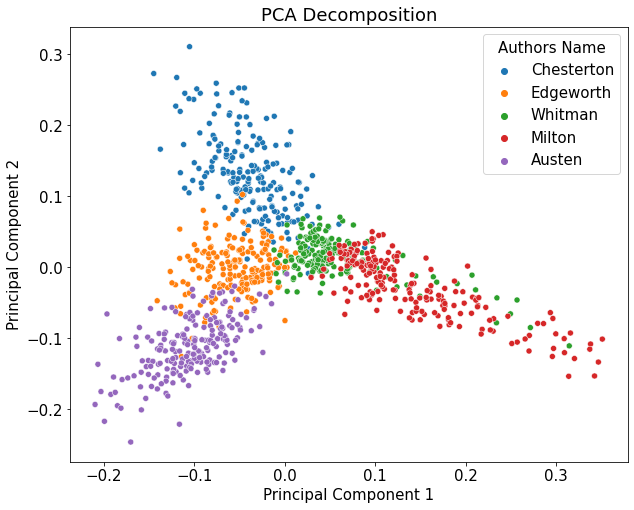

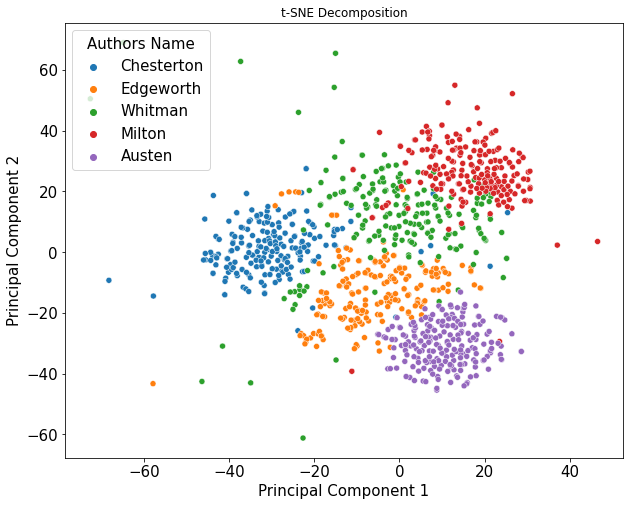

In [ ]:
# different type of preprocessing are used to check the effect of stemming, stop words, lemmatization text represenation
x=df_books['lemm_nostopwords_text']
#x=df_books['books_text_data']
#x=df_books['stem_text']
#x=df_books['lemmatized_text']
#x=df_books['text_no_stopwords']
y=df_books['labels_encoder']
import seaborn as sns
text_labels = y
from sklearn.decomposition import PCA
principal_components = PCA(n_components=2).fit_transform(TF_iDF) # Fit and transform
df_PCA = pd.DataFrame(principal_components, columns=['Principal Component 1', 'Principal Component 2'])
df_PCA['Authors Labels']=y
df_PCA['Authors Name']=le.inverse_transform(y)

plt.figure(figsize=(10,8))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue="Authors Name",
                data=df_PCA).set_title('PCA Decomposition')
#--------------
from sklearn.manifold import TSNE
principal_components = TSNE(n_components=2).fit_transform(TF_iDF) # Fit and transform
df_TSNE = pd.DataFrame(principal_components, columns=['Principal Component 1', 'Principal Component 2'])
df_TSNE['Authors Labels']=y
df_TSNE['Authors Name']=le.inverse_transform(y)

plt.figure(figsize=(10,8))
b=sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue="Authors Name",
                data=df_TSNE).set_title('t-SNE Decomposition', fontsize = 12)
#sns.set(font_scale=1.4)


# **EM Clustering Model**

**Modelling EM**

In [ ]:
#Expectation Maximization
def EM(vector):
    from sklearn.mixture import GaussianMixture
    #from sklearn import preprocessoring
    gmm = GaussianMixture(n_components=5, random_state=0).fit(vector)
    EM_clusters = gmm.predict(vector)
    return EM_clusters

**PCA Implemenatation**

To reduce the high dimentional vectors into 2 dimentions.

In [ ]:
def pca(vector):
  from sklearn.decomposition import PCA
  pca_trans = PCA(n_components=2).fit_transform(vector)
  PCA_components = pd.DataFrame(data = pca_trans)
  return pca_trans,PCA_components

**Get the Features**

Obtain the features from reduced dimentional vectors:

In [ ]:
pca_bow,PCA_components_bow=pca(BOW)
pca_tfidf,PCA_components_tfidf=pca(TF_iDF)
pca_lda,PCA_components_lda=pca(lda_output)
pca_WE,PCA_components_WE=pca(cbow_model.wv.vectors)

**Function for Mertrics Calculation**

*Silhouette*
- A measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
- Range = [-1, 1];
- The higher value, the better avg match is within the cluster.

*kappa*
- The kappa  is a number between -1 and 1. 
- The maximum value means complete agreement; zero or lower means chance agreement.

*Adjusted Rand Index (ARI)*

-Rand Index is a function that computes a similarity measure between two clustering.
- Perfect labeling would be scored 1 and bad labelling or independent labelling is scored 0 or negative.

*Adjusted Mutual Information (AMI)*
- 0 (no mutual information - variables are independent) to +∞. The higher the, the more information is shared between variables.

*Homogeneity*

- A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
- score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling ((low values indicating a low homogeneity))

*Completeness*

- A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.
- score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling

In [ ]:
# Clustering Mertrics calculation
def clustering_metrics(labels,clusters,vector,model):
  from scipy.stats import spearmanr
  from sklearn import metrics
  kappa=metrics.cohen_kappa_score(labels, clusters,weights='linear')
  cluster_silhouette=metrics.silhouette_score(vector, clusters, metric='euclidean'),
  human_silhouette=metrics.silhouette_score(vector,labels,metric='euclidean')
  homogeneity=metrics.homogeneity_score(labels, clusters)
  completeness=metrics.completeness_score(labels, clusters)
  v_meas=metrics.v_measure_score(labels, clusters)
  ARI=metrics.adjusted_rand_score(labels, clusters)
  AMI=metrics.adjusted_mutual_info_score(labels,clusters)
  cluster_metrics=pd.DataFrame({'kappa':kappa,'cluster_silhouette':cluster_silhouette,
                              'human_silhouette':human_silhouette, 'homogeneity':homogeneity,
                              'completeness':completeness,'v_meas':v_meas,
                             'ARI':ARI,'AMI':AMI},index=[model])
  return cluster_metrics

**Functions to Visualize the Clusters**

For visualization purpose, we will use PCA and TSNE to reduce the dimension into 2 dimensions before plotting (transform high dimensional features into 2 dimensions) since the the dimension of obtained features is large.
- After reducing features and cluster centers into 2D, we can plot those points using a scatter plot. 
- The first dimension will be used as X values and second dimension will be used as Y values in a XY plot. 

From the plots below we can see that apart from the rightmost cluster, others seems to be scattered all around and overlapping as well.

In [ ]:
def cluster_visualization(vector,cluster_model,title):
  from sklearn.decomposition import PCA
  PCA_points = PCA(n_components=2).fit_transform(vector)
  fig, ax = plt.subplots(figsize=(16,8))
  ax.scatter(PCA_points[:, 0], PCA_points[:, 1], c=cluster_model, s=40, cmap='viridis')
  ax.set_title(title[0], fontsize = 12,fontweight='bold')
  ax.set_xlabel('PC1', fontsize = 12,fontweight='bold')
  ax.set_ylabel('PC2', fontsize = 12,fontweight='bold')
  #from sklearn.manifold import TSNE
  #TSNE_points = TSNE(n_components=2).fit_transform(vector) # Fit and transform
  #fig, ax = plt.subplots(figsize=(16,8))
  #ax.scatter(TSNE_points[:, 0], TSNE_points[:, 1], c=cluster_model, s=40, cmap='viridis')
  #ax.set_title(title[1], fontsize = 12,fontweight='bold')
  #ax.set_xlabel('PC1', fontsize = 12,fontweight='bold')
  #ax.set_ylabel('PC2', fontsize = 12,fontweight='bold')

In [ ]:
import matplotlib as mpl
from pylab import *
def cluster_visualization1(vector,cluster_model,title):
  # title=[title1, title2] 
  from sklearn.decomposition import PCA
  PCA_points = PCA(n_components=2).fit_transform(vector)
  fig, ax = plt.subplots(figsize=(16,8))
  ax.scatter(PCA_points[:, 0], PCA_points[:, 1], c=cluster_model, s=40, cmap='viridis')
  ax.set_title(title[0], fontsize = 12,fontweight='bold')
  ax.set_xlabel('PC1', fontsize = 12,fontweight='bold')
  ax.set_ylabel('PC2', fontsize = 12,fontweight='bold')

 
  mpl.rcParams["axes.spines.right"] = False; mpl.rcParams["axes.spines.top"] = False
  rc('axes', linewidth=3)
  fontsize = 12
  ax1 = gca()
  for tick in ax1.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
  for tick in ax1.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')

  from sklearn.manifold import TSNE
  TSNE_points = TSNE(n_components=2).fit_transform(vector) # Fit and transform
  fig, ax = plt.subplots(figsize=(16,8))
  ax.scatter(TSNE_points[:, 0], TSNE_points[:, 1], c=cluster_model, s=40, cmap='viridis')
  ax.set_title(title[1], fontsize = 12,fontweight='bold')
  ax.set_xlabel('PC1', fontsize = 12,fontweight='bold')
  ax.set_ylabel('PC2', fontsize = 12,fontweight='bold')
  
  mpl.rcParams["axes.spines.right"] = False; mpl.rcParams["axes.spines.top"] = False
  rc('axes', linewidth=3)
  fontsize = 12
  ax1 = gca()
  for tick in ax1.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
  for tick in ax1.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')

**EM Model Using TFiDF**


In [ ]:
# Train the model with obtained features
EM_clusters = EM(pca_tfidf)

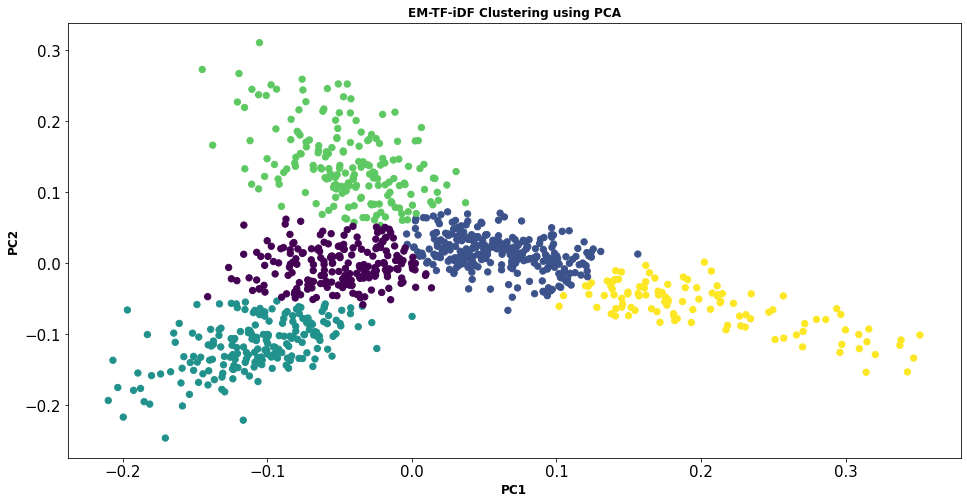

In [ ]:
title=['EM-TF-iDF Clustering using PCA']
EM_TFiDF_visualization=cluster_visualization(TF_iDF,EM_clusters,title)

In [ ]:
EM_TFiDF_metrics=clustering_metrics(y,EM_clusters,pca_tfidf,'TF-iDF')
EM_TFiDF_metrics

,kappa,cluster_silhouette,human_silhouette,homogeneity,completeness,v_meas,ARI,AMI
TF-iDF,-0.262431,0.470119,0.305854,0.665675,0.686831,0.676088,0.612186,0.674433


Check if clustering result is  close to the human labels:


In [ ]:
# Check if clustering result is close to the human labels:
df_data=pd.DataFrame({'Authors':df_books['authors_labels'],
                  'Authors_Labels':df_books['labels_encoder'],
                  'Cluster_Labels': EM_clusters})
df_data.sample(5)

,Authors,Authors_Labels,Cluster_Labels
785,Milton,3,1
694,Milton,3,4
445,Whitman,4,1
830,Austen,0,2
272,Edgeworth,2,1


In [ ]:
df_data['Cluster_Labels'].value_counts()

1    304
0    206
2    199
3    183
4    108
Name: Cluster_Labels, dtype: int64

In [ ]:
# Contingency Matrix
# This matrix will report the intersection cardinality for every trusted pair of (true, predicted).
from sklearn.metrics.cluster import contingency_matrix
y=df_books['labels_encoder']
contingency_matrx = contingency_matrix(y, EM_clusters)
contingency_matrx

array([[ 17,   0, 183,   0,   0],
       [  7,  16,   0, 177,   0],
       [171,   7,  16,   6,   0],
       [  0, 107,   0,   0,  93],
       [ 11, 174,   0,   0,  15]])

** Contingency matrix **

It reports the intersection cardinality for every true/predicted cluster pair.

The contingency matrix provides sufficient statistics for all clustering metrics where the samples are independent and identically distributed and one doesn’t need to account for some instances not being clustered.

In [ ]:
def cont_matrix(y,EM_clusters):
  from sklearn.metrics.cluster import contingency_matrix
  labels_df = df_books[['authors_labels', 'labels_encoder']].drop_duplicates().sort_values('labels_encoder')
  font = {'family': 'serif','color':  'darkred','weight': 'bold','size': 14}
  EM_contingency_matrix=contingency_matrix(y, EM_clusters)
  plt.figure(figsize=(10,3))
  sns.heatmap(EM_contingency_matrix, 
            annot=True,
            xticklabels=labels_df['authors_labels'].values, 
            yticklabels=labels_df['authors_labels'].values,
            cmap="Greens")
  plt.ylabel('Clustered',fontdict=font)
  plt.xlabel('Actual',fontdict=font)
  plt.title('Contingency Matrix EM',fontdict=font)
  plt.xticks(fontsize=12);plt.yticks(fontsize=12)
  plt.show()

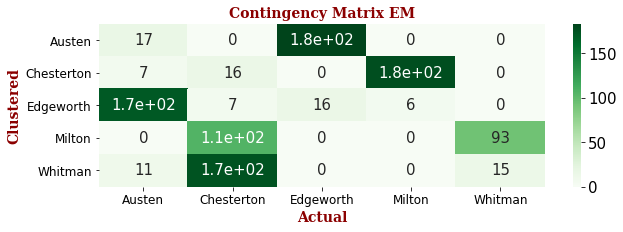

In [ ]:
cont_matrix(y,EM_clusters)

## Cosine similarity plot
- Cosine similarity is a measure of similarity that can be used to compare documents or, say, give a ranking of documents with respect to a given vector of query words
- Cosine similarity measures the similarity between two vectors of an inner product space. 
- It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction. 
- It is often used to measure document similarity in text analysis.

In [ ]:
def cosine_dist(vector):
  from sklearn.metrics.pairwise import cosine_similarity
  cosine_dist = 1 - cosine_similarity(vector)
  return cosine_dist

**Multidimensional scaling (MDS)**
- Multidimensional scaling (MDS) seeks a low-dimensional representation of the 
data in which the distances respect well the distances in the original high-dimensional space.
- In general, MDS is a technique used for analyzing similarity or dissimilarity data. 
- It attempts to model similarity or dissimilarity data as distances in a geometric spaces. 

In [ ]:
cosine_dist=cosine_dist(TF_iDF)

In [ ]:
def plot_cosine_dist(cosine_dist,clusters_labels,title):
  from sklearn.manifold import MDS
  pos = MDS(n_components=2, dissimilarity="precomputed").fit_transform(cosine_dist)
  xs, ys = pos[:, 0], pos[:, 1] #cluster_names =le.inverse_transform(EM_clusters)
  cluster_names = {0: 'Cluster 1', 1:'Cluster 2', 2:'Cluster 3', 3:'Cluster 4', 4:'Cluster 5'}
  df = pd.DataFrame(dict(x=xs, y=ys, label=clusters_labels)) 
  groups = df.groupby('label')
  fig, ax = plt.subplots(figsize=(15, 10))
  for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,label=cluster_names[name], mec='none')
    ax.set_aspect('auto')
  ax.set_title(title, fontsize = 12,fontweight='bold')
  ax.set_xlabel('PC1', fontsize = 12,fontweight='bold')
  ax.set_ylabel('PC2', fontsize = 12,fontweight='bold')
  ax.legend(); plt.show() 

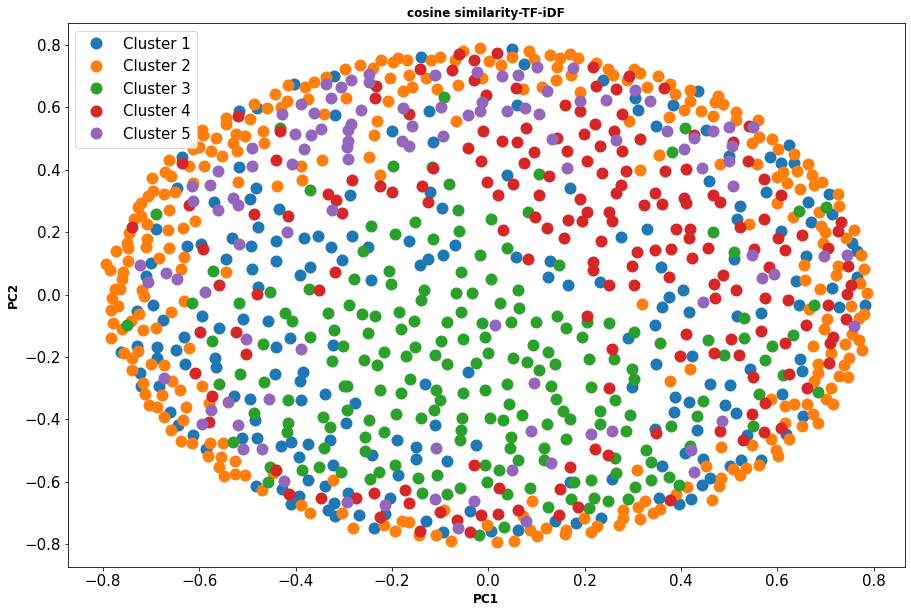

In [ ]:
title='cosine similarity-TF-iDF'
plot_cosine_dist(cosine_dist,EM_clusters,title)

**EM-BOW**


In [ ]:
# Use BOW with EM
EM_BOW = EM(pca_bow)

In [ ]:
EM_BOW_metrics=clustering_metrics(y,EM_BOW,pca_bow,'BOW')
EM_BOW_metrics

,kappa,cluster_silhouette,human_silhouette,homogeneity,completeness,v_meas,ARI,AMI
BOW,-0.315309,0.375084,0.116716,0.395731,0.430193,0.412243,0.303382,0.409157


In [ ]:
df_EM_BOW=pd.DataFrame({'Authors':df_books['authors_labels'],
                  'Authors_Labels':df_books['labels_encoder'],
                  'Cluster_Labels': EM_BOW})
df_EM_BOW.sample(5)

,Authors,Authors_Labels,Cluster_Labels
722,Milton,3,2
81,Chesterton,1,4
595,Whitman,4,1
519,Whitman,4,3
906,Austen,0,3


In [ ]:
df_EM_BOW['Cluster_Labels'].value_counts()

3    321
1    302
0    190
2    114
4     73
Name: Cluster_Labels, dtype: int64

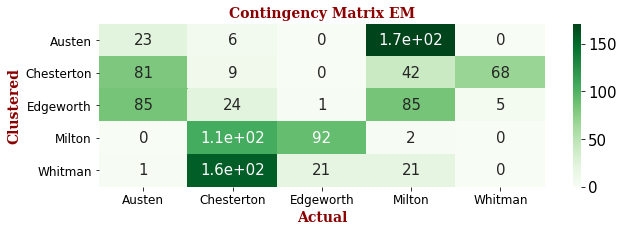

In [ ]:
cont_matrix(y,EM_BOW)

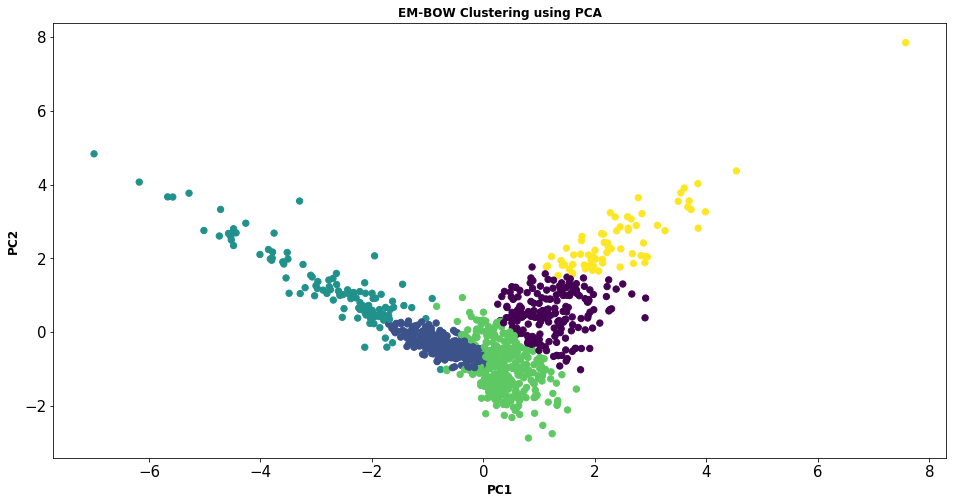

In [ ]:
title=['EM-BOW Clustering using PCA']
EM_BOW_visualization=cluster_visualization(pca_bow,EM_BOW,title)

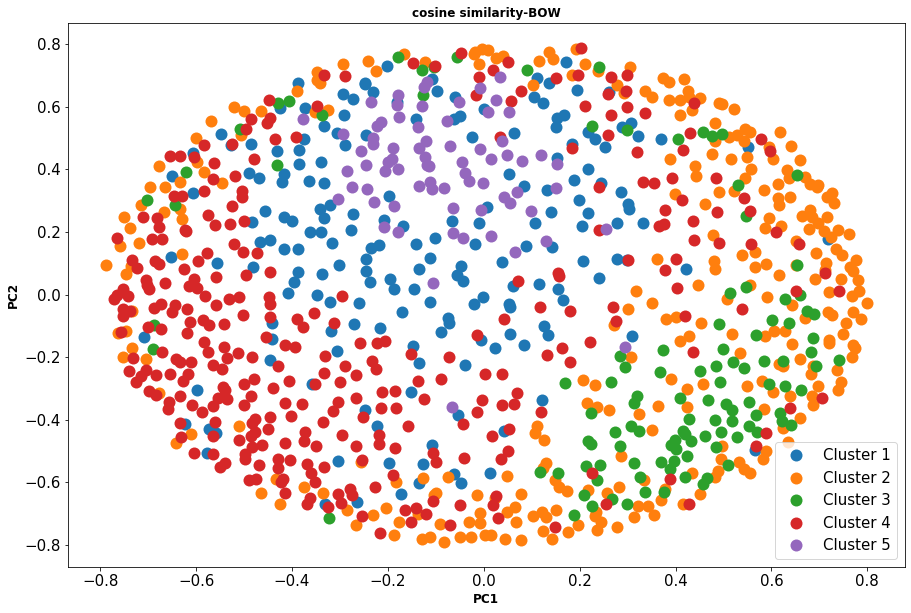

In [ ]:
title='cosine similarity-BOW'
cosine_dist=cosine_dist(BOW)
plot_cosine_dist(cosine_dist,EM_BOW,title)


Evaluation for unsupervised learning algorithms is a bit difficult and requires human judgement but there are some metrics which you might use. There are two kinds of metrics you can use depending on whether or not you have the labels. For most of the clustering problems, you probably won’t have labels. If you had you’d do classification instead. But it is what it is. Here are a couple of them which I want to show you but you can read about other metrics on your own.

**Evalauation with labelled dataset**
If you have labelled dataset then you can use few metrics that give you an idea of how good your clustering model is.
- Homogeneity score ranges between 0 and 1 where 1 stands for perfectly homogeneous labeling.

**Evaluation with unlabelled dataset**

If you don’t have labels for your dataset, then you can still evaluate your clustering model with some metrics. 

One of them is Silhouette Coefficient.

- The best value is 1 and the worst value is -1. 
- Values near 0 indicate overlapping clusters. 
- Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.


**EM-LDA**


In [ ]:
#pca_lda,PCA_components_lda=pca(lda_output)
#pca_WE,PCA_components_WE=pca(sg_model.wv.vectors)

In [ ]:
EM_LDA = EM(pca_lda)

In [ ]:
EM_LDA_metrics=clustering_metrics(y,EM_LDA,pca_lda,'LDA')
EM_LDA_metrics

,kappa,cluster_silhouette,human_silhouette,homogeneity,completeness,v_meas,ARI,AMI
LDA,0.294998,0.493751,-0.153249,0.279566,0.356818,0.313503,0.225429,0.309599


In [ ]:
df_EM_LDA=pd.DataFrame({'Authors':df_books['authors_labels'],
                  'Authors_Labels':df_books['labels_encoder'],
                  'Cluster_Labels': EM_LDA})
df_EM_LDA.sample(5)

,Authors,Authors_Labels,Cluster_Labels
575,Whitman,4,2
794,Milton,3,2
462,Whitman,4,4
34,Chesterton,1,0
759,Milton,3,4


In [ ]:
df_EM_LDA['Cluster_Labels'].value_counts()

0    499
2    273
4    131
1     51
3     46
Name: Cluster_Labels, dtype: int64

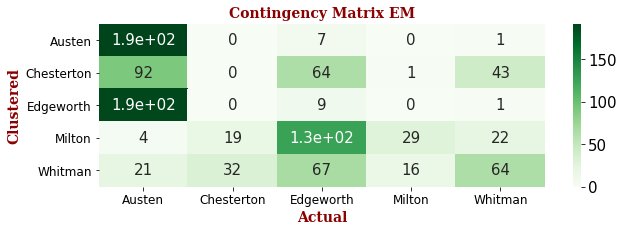

In [ ]:
cont_matrix(y,EM_LDA)

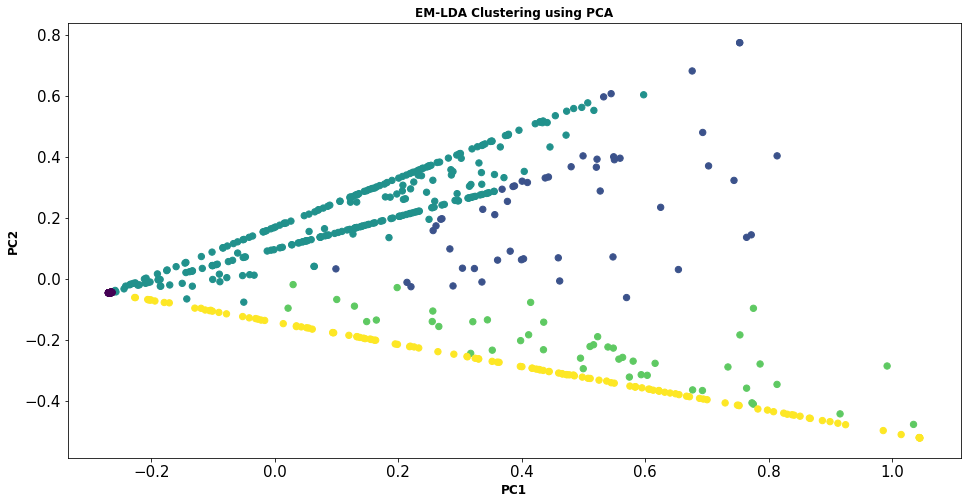

In [ ]:
title=['EM-LDA Clustering using PCA','EM-LDA Clustering using TSNE']
EM_LDA_visualization=cluster_visualization(pca_lda,EM_LDA,title)

**EM-WE**


In [ ]:
EM_WE = EM(pca_WE)

In [ ]:
from sklearn import metrics
kappa_WE=metrics.cohen_kappa_score(y, EM_WE[:1000],weights='linear')
WE_cluster_silhouette=metrics.silhouette_score(pca_WE, EM_WE, metric='euclidean')
print('The cluster silhouette using WE = {}'.format(WE_cluster_silhouette))
model='WE'
EM_WE_metrics=pd.DataFrame({'kappa':'--','cluster_silhouette':[WE_cluster_silhouette],
                              'human_silhouette':'--', 'homogeneity':'--',
                              'completeness':'--','v_meas':'--',
                             'ARI':'--','AMI':'--'}, index=[model])

The cluster silhouette using WE = 0.36179500818252563


In [ ]:
EM_WE_metrics

,kappa,cluster_silhouette,human_silhouette,homogeneity,completeness,v_meas,ARI,AMI
WE,--,0.361795,--,--,--,--,--,--


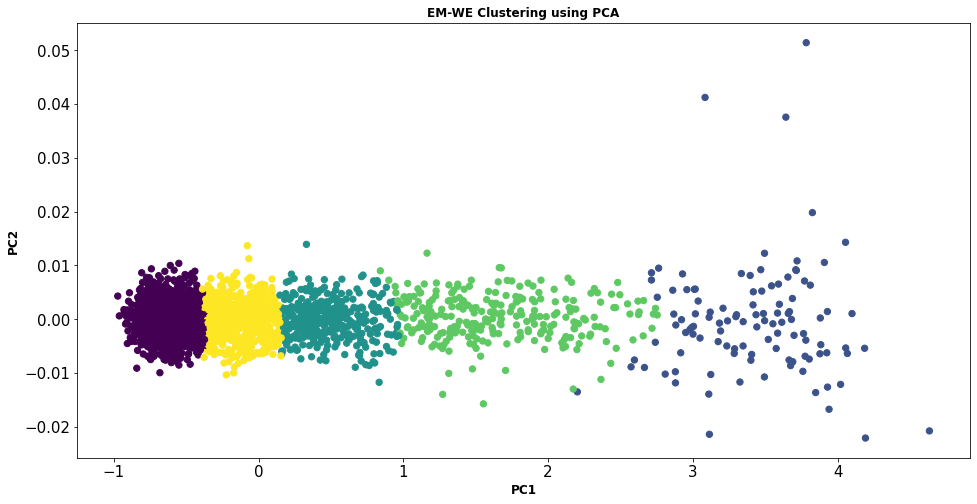

In [ ]:
title=['EM-WE Clustering using PCA','EM-WE Clustering using TSNE']
EM_WE_visualization=cluster_visualization(pca_WE,EM_WE,title)

**Summerize the metrics**


In [ ]:
EM_metrics=[EM_TFiDF_metrics,EM_BOW_metrics,EM_LDA_metrics,EM_WE_metrics]
df_summary = pd.DataFrame()
for df in EM_metrics:
  #df_summary=df_summary.append(df).reset_index().drop('index', axis=1)
  df_summary=df_summary.append(df)
df_summary

,kappa,cluster_silhouette,human_silhouette,homogeneity,completeness,v_meas,ARI,AMI
TF-iDF,-0.262431,0.470119,0.305854,0.665675,0.686831,0.676088,0.612186,0.674433
BOW,-0.315309,0.375084,0.116716,0.395731,0.430193,0.412243,0.303382,0.409157
LDA,0.294998,0.493751,-0.153249,0.279566,0.356818,0.313503,0.225429,0.309599
WE,--,0.361795,--,--,--,--,--,--


In [ ]:

df_summary.to_excel("EM.xlsx", index=True)
#df_books1.to_csv('students.csv', index=False)
#filename = '/content/output.xlsx'
#df2 = pd.read_excel(filename)
# Load car loan data from a csv file
#filename = '/content/students.csv'
#df3 = pd.read_csv(filename)

In [ ]:
#df_summary.sort_values('cluster_silhouette', ascending=True).reset_index().drop('index', axis=1) # And sort it by Test Accuracy:
df_summary.sort_values('cluster_silhouette', ascending=True)

,kappa,cluster_silhouette,human_silhouette,homogeneity,completeness,v_meas,ARI,AMI
WE,--,0.361795,--,--,--,--,--,--
BOW,-0.315309,0.375084,0.116716,0.395731,0.430193,0.412243,0.303382,0.409157
TF-iDF,-0.262431,0.470119,0.305854,0.665675,0.686831,0.676088,0.612186,0.674433
LDA,0.294998,0.493751,-0.153249,0.279566,0.356818,0.313503,0.225429,0.309599


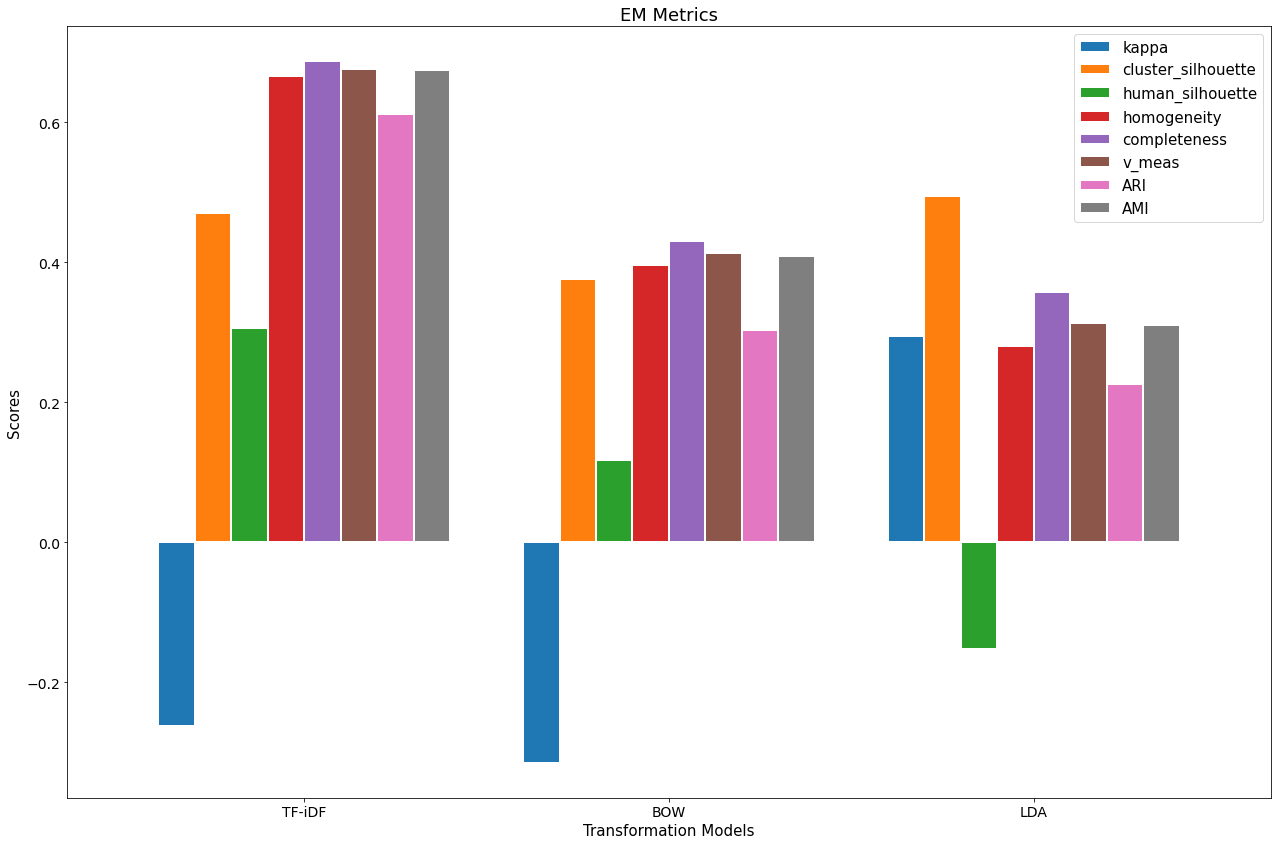

In [ ]:
vis_df1=df_summary[:3]
vis_df1
ax = vis_df1.plot.bar(fontsize=14, xlabel='Transformation Models', ylabel='Scores', width=0.8,rot=0,figsize=(18,12),
                      title="EM Metrics",alpha=1,
                      edgecolor='white', linewidth=2)
plt.tight_layout()
plt.show(block=True)
import pylab as plot
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}     
plot.rcParams.update(params)
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

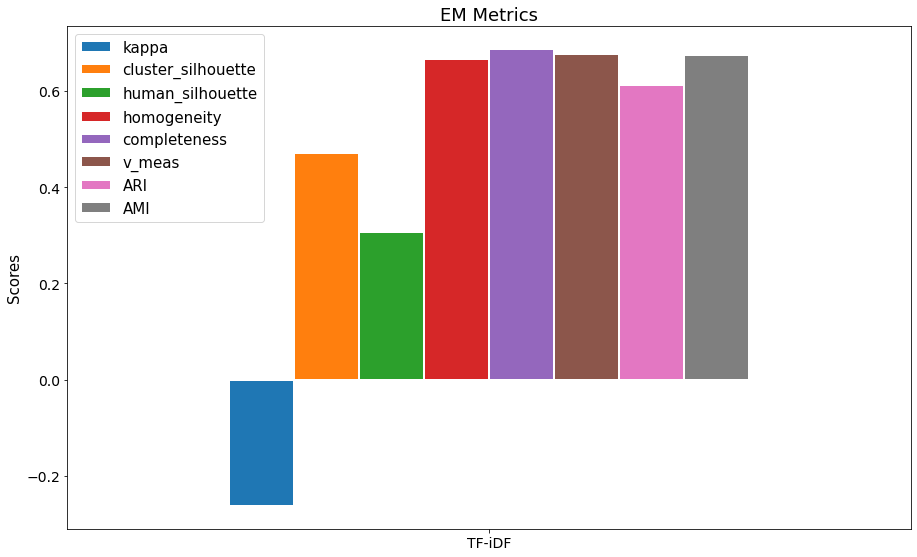

In [ ]:
vis_df1=df_summary[:1]
vis_df1
ax = vis_df1.plot.bar(fontsize=14, ylabel='Scores',
                      width=0.8,rot=0,figsize=(13,8),
                      title="EM Metrics",alpha=1,edgecolor='white', linewidth=2)
plt.tight_layout()
plt.show(block=True)
import pylab as plot
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plot.rcParams.update(params)

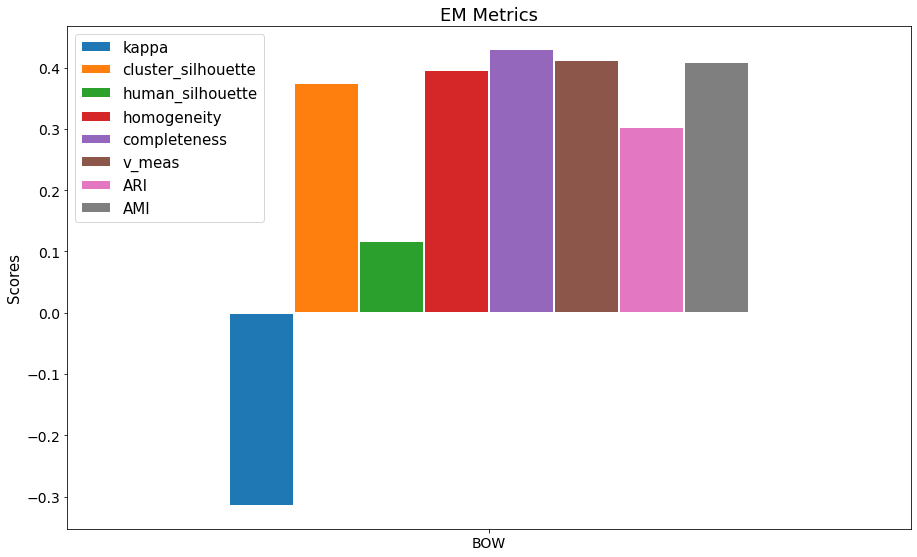

In [ ]:
vis_df1=df_summary[1:2]
vis_df1
ax = vis_df1.plot.bar(fontsize=14, ylabel='Scores',width=0.8,
                      rot=0,figsize=(13,8),title="EM Metrics",alpha=1,edgecolor='white', linewidth=2)
plt.tight_layout()
plt.show(block=True)
import pylab as plot
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plot.rcParams.update(params)

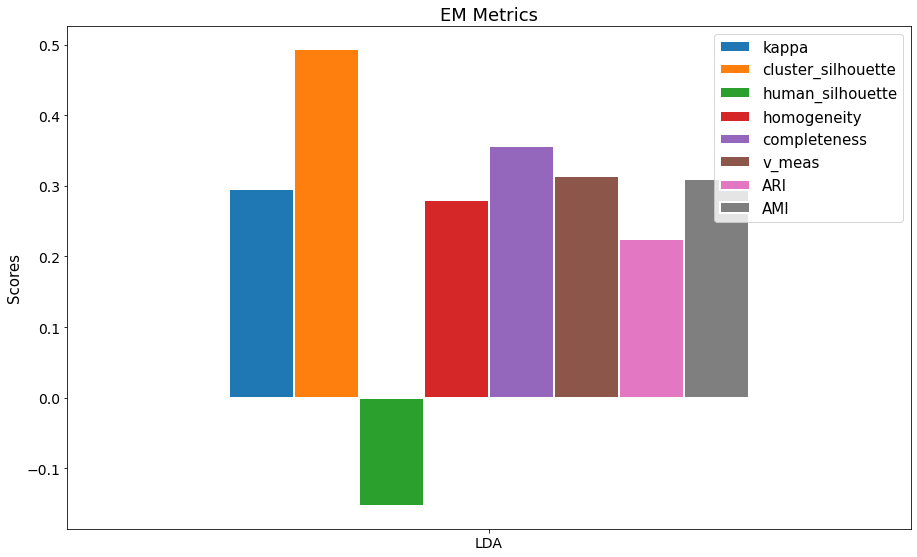

In [ ]:
vis_df1=df_summary[2:3]
vis_df1
ax = vis_df1.plot.bar(fontsize=14, ylabel='Scores',
                      width=0.8,rot=0,figsize=(13,8),title="EM Metrics",alpha=1,edgecolor='white', linewidth=2)
plt.tight_layout()
plt.show(block=True)
import pylab as plot
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plot.rcParams.update(params)

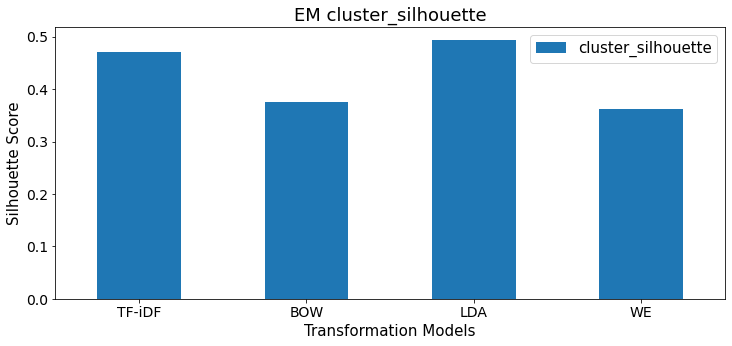

In [ ]:
vis_df=df_summary[['cluster_silhouette']]
vis_df
ax = vis_df.plot.bar(fontsize=14, xlabel='Transformation Models', ylabel='Silhouette Score',rot=0,figsize=(12,5),title="EM cluster_silhouette",legend=True)